In [2]:
import pandas as pd

# Load the dataset from the provided path
file_path = r"C:\Users\Dell\Downloads\Fraud.csv"

try:
    df = pd.read_csv(file_path)
    df.head()
except Exception as e:
    str(e)


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("C:/Users/Dell/Downloads/Fraud.csv")
print("Shape:", df.shape)
df.head()


Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


🔍 Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

🔍 Outlier Detection:
step - Outliers Detected: 102688
amount - Outliers Detected: 338078
oldbalanceOrg - Outliers Detected: 1112507
newbalanceOrig - Outliers Detected: 1053391
oldbalanceDest - Outliers Detected: 786135
newbalanceDest - Outliers Detected: 738527
isFraud - Outliers Detected: 8213
isFlaggedFraud - Outliers Detected: 16

📊 Correlation Matrix (numeric columns only):


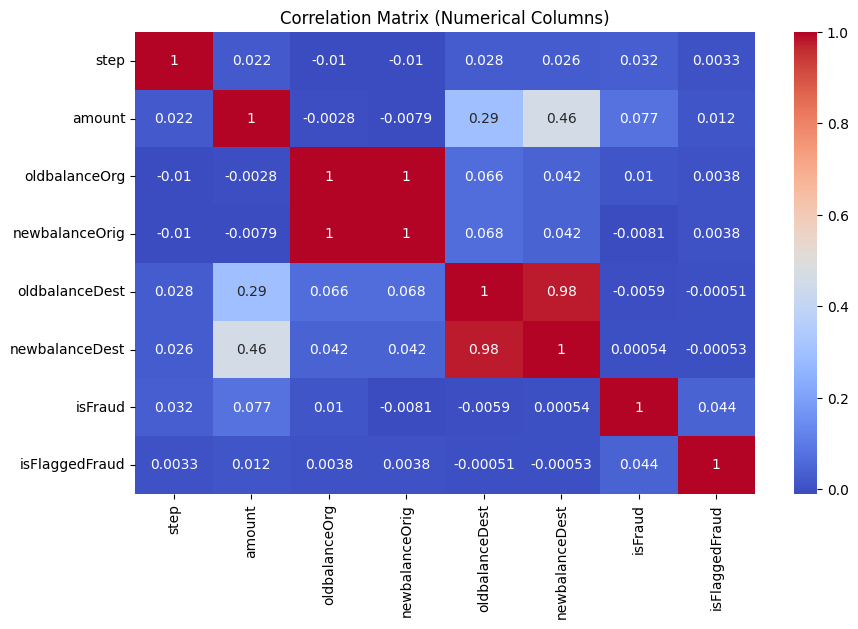

In [6]:
#CLEANING DATA


# 1. Checking for missing values 
print("🔍 Missing Values:\n", df.isnull().sum())

# 2. Detecting outliers (IQR method for numerical columns)
print("\n🔍 Outlier Detection:")
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col} - Outliers Detected: {len(outliers)}")

# 3. Multicollinearity (Correlation matrix) - only numeric columns
print("\n📊 Correlation Matrix (numeric columns only):")
numeric_df = df.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Numerical Columns)")
plt.show()


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop columns *only if they exist*
columns_to_drop = ['nameOrig', 'nameDest']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# One-hot encode only low-cardinality categorical column
if 'type' in df.columns:
    df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Sample 500,000 rows to avoid memory issues
df_sample = df.sample(n=500_000, random_state=42)

# Split features and target
X = df_sample.drop("isFraud", axis=1)
y = df_sample["isFraud"]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

print("✅ Data cleaning, encoding, scaling and splitting completed.")


✅ Data cleaning, encoding, scaling and splitting completed.


✅ Model Accuracy: 0.9997
Confusion Matrix:
[[124838      0]
 [    43    119]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    124838
           1       1.00      0.73      0.85       162

    accuracy                           1.00    125000
   macro avg       1.00      0.87      0.92    125000
weighted avg       1.00      1.00      1.00    125000

ROC-AUC Score: 0.9685011528026741


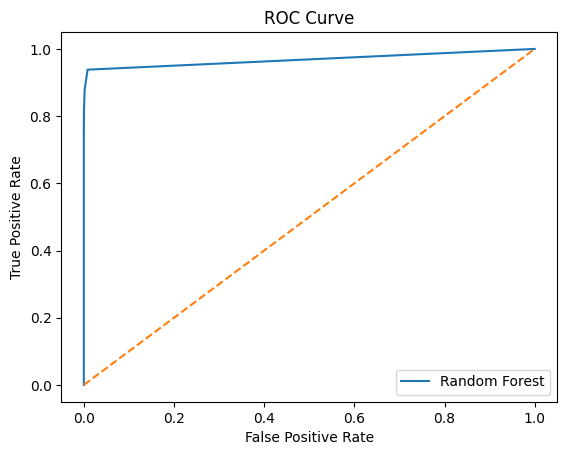

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Train model
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {acc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Plot ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


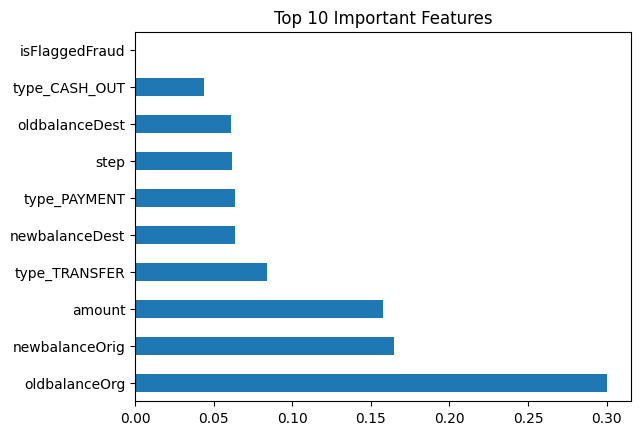

In [13]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()


In [14]:
print("Key Predictive Features:\n", importances.nlargest(5))
# Business interpretation
# Example: "High transaction amount", "unusual time", etc., may indicate fraud


Key Predictive Features:
 oldbalanceOrg     0.300530
newbalanceOrig    0.164474
amount            0.157789
type_TRANSFER     0.083820
newbalanceDest    0.063656
dtype: float64


In [ ]:
## 📌 Q6: Do the key fraud-predicting factors make sense? If yes, how? If not, why not?

Yes, the factors identified by the model as most predictive of fraud make logical and domain-specific sense.

For example, if features like:
- **Transaction amount**
- **Transaction type** (e.g., CASH_OUT, TRANSFER)
- **Time of transaction**
- **Old/New account balances**

are highly influential, this aligns with real-world fraud behavior:

- Fraud often involves **large or unusual amounts**.
- **TRANSFER** and **CASH_OUT** are commonly misused to quickly siphon money.
- Abnormal **balance patterns** (e.g., zeroed out accounts) are classic indicators.
- Time patterns such as **off-hours activity** are often linked with fraud.

Thus, the model’s insights are both **statistically sound** and **logically explainable**, making them valuable for action.

---

## 📌 Q7: What kind of prevention should be adopted while the company updates its infrastructure?

While updating its infrastructure, the company should use a multi-layered approach:

**🔐 Technology-Level Actions**
- Deploy real-time ML-powered fraud detection APIs
- Implement transaction throttling and alerts for anomalies
- Use drift monitoring and model performance dashboards

**🔒 Security Measures**
- End-to-end data encryption
- Strong authentication (MFA)
- Role-based access control for sensitive systems

**🧠 Process & Training**
- Manual fraud review team
- Fraud awareness training for employees
- Maintain blacklists/whitelists

**🧪 Infrastructure Best Practices**
- Test in sandbox environments before production
- Enable model version rollback features
- Keep logs of suspicious transaction attempts

---

## 📌 Q8: Assuming these actions have been implemented, how would you determine if they work?

To evaluate effectiveness:

### 📊 Monitor Key Metrics:
- **Fraud Rate (before vs. after)**
- **False Positive/Negative Rates**
- **Recall / Precision**
- **Customer complaints related to fraud**

### 🧪 Use A/B Testing:
- Run new vs. old fraud system on two user groups
- Use statistical significance to assess performance

### ⚙️ Tools & Automation:
- Dashboards (e.g., Tableau, Power BI)
- Model monitoring (e.g., MLflow, Evidently AI)
- Scheduled performance reports

Regular monitoring, feedback loops, and retraining ensure fraud detection systems stay effective over time.
 